
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## Lecture 18: Autoencoders Example 

**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors:** Pavlos Protopapas and Mark Glickman<br/>

<hr style="height:2pt">


Code and ideas taken/borrowed/adapted from 
Deep Learning From Basics to Practice, by Andrew Glassner, https://dlbasics.com, http://glassner.com, Python utilities for saving and loading files, mostly images and Keras model weights


In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense
import numpy as np
#import h5py
#from pathlib import Path
import matplotlib.pyplot as plt

from keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

Using TensorFlow backend.
/Users/pavlos/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
# I will be saving everything so I can re-use them 
save_files = True

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [4]:
random_seed = 52
np.random.seed(random_seed)

# Read MNIST data. Of course we will not be using y_train and y_test
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Full size of the image 28x28 
N_pixels = X_train.shape[1]*X_train.shape[2]

# Convert to floats
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# Normalize the range from [0,255] to [0,1]
X_train /= 255.
X_test /= 255.

# Reshape the data into a grid with one row per sample, each row 784 (28*28) pixels
X_train = X_train.reshape((len(X_train), N_pixels))
X_test = X_test.reshape((len(X_test), N_pixels))

print("X_train.shape = ",X_train.shape, " X_test.shape = ",X_test.shape)

X_train.shape =  (60000, 784)  X_test.shape =  (10000, 784)


In [5]:
def draw_predictions_set(predictions, filename=None):
    plt.figure(figsize=(8, 4))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.subplot(2, 5, i+6)
        plt.imshow(predictions[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    file_helper.save_figure(filename+'-predictions')
    plt.show()

In [28]:
# Build and train our first autoencoder
num_latent_vars = 20

modelAE1 = Sequential()
modelAE1.add(Dense(num_latent_vars, input_dim=N_pixels, activation='relu'))
modelAE1.add(Dense(N_pixels, activation='linear'))
modelAE1.compile(optimizer='adadelta', loss='mse')


weights_filename = "modelAE1-weights"
np.random.seed(52)
if not file_helper.load_model_weights(modelAE1, weights_filename):
    modelAE1.fit(X_train, X_train,
                   epochs=20, batch_size=128, shuffle=True,
                   verbose=2,
                   validation_data=(X_test, X_test))
    file_helper.save_model_weights(modelAE1, weights_filename)

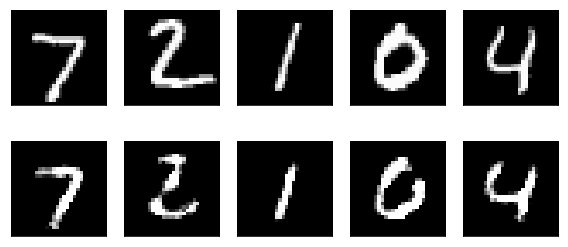

In [29]:
predictions1 = modelAE1.predict(X_test)
draw_predictions_set(predictions1, 'FCC1')

In [30]:
# Build and train our first autoencoder
num_latent_vars = 20

modelAE1_s = Sequential()
modelAE1_s.add(Dense(num_latent_vars, input_dim=N_pixels, activation='relu'))
modelAE1_s.add(Dense(N_pixels, activation='sigmoid'))
modelAE1_s.compile(optimizer='adadelta', loss='binary_crossentropy')


weights_filename = "modelAE1-weights-sigmoid"
np.random.seed(52)
if not file_helper.load_model_weights(modelAE1_s, weights_filename):
    modelAE1_s.fit(X_train, X_train,
                   epochs=20, batch_size=128, shuffle=True,
                   verbose=2,
                   validation_data=(X_test, X_test))
    file_helper.save_model_weights(modelAE1_s, weights_filename)

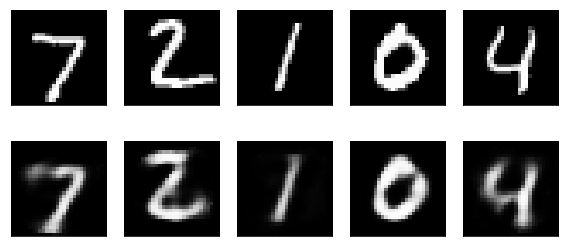

In [9]:
predictions1 = modelAE1_s.predict(X_test)
draw_predictions_set(predictions1, 'FCC1-s')

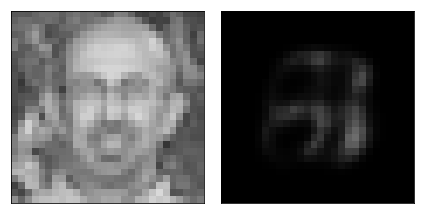

In [31]:
from PIL import Image

filepath = file_helper.get_input_file_path("pavlos-gray-28-28.png")
im = Image.open(filepath) 
pix = im.load()
pavlos = np.zeros((1,784))
for y in range(28):
    for x in range(28):
        pavlos[0,(y*28)+x] = pix[x,y][0]/255.
        
predicted_pavlos = modelAE1_s.predict(pavlos)

plt.subplot(1, 2, 1)
plt.imshow(np.reshape(pavlos, (28, 28)), vmin=0, vmax=1, cmap="gray")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.subplot(1, 2, 2)
plt.imshow(np.reshape(predicted_pavlos, (28, 28)), vmin=0, vmax=1, cmap="gray")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
file_helper.save_figure('Model-FCC-pavlos-pair')
plt.show()

In [33]:
# rebuild model with the Functional API so we can play with the decoder alone
from keras.layers import Input

num_latent_vars = 20

model_encoder_input = Input(shape=(784,))
model_encoder_512 = Dense(512, activation='relu')
model_encoder_256 = Dense(256, activation='relu')
model_encoder_latent = Dense(num_latent_vars, activation='relu')

model_decoder_256 = Dense(256, activation='relu')
model_decoder_512 = Dense(512, activation='relu')
model_decoder_out = Dense(784, activation='sigmoid')

model_encoder_step_1 = model_encoder_512(model_encoder_input)
model_encoder_step_2 = model_encoder_256(model_encoder_step_1)
model_encoder_output = model_encoder_latent(model_encoder_step_2)

model_decoder_step_1 = model_decoder_256(model_encoder_output)
model_decoder_step_2 = model_decoder_512(model_decoder_step_1)
model_decoder_output = model_decoder_out(model_decoder_step_2)

model_AE_F = Model(model_encoder_input, model_decoder_output)

model_encoder_only_model = Model(model_encoder_input, model_encoder_output)

model_decoder_only_input = Input(shape=(num_latent_vars,))
model_decoder_only_step_1 = model_decoder_256(model_decoder_only_input)
model_decoder_only_step_2 = model_decoder_512(model_decoder_only_step_1)
model_decoder_only_output = model_decoder_out(model_decoder_only_step_2)
model_decoder_only_model = Model(model_decoder_only_input, model_decoder_only_output)

In [36]:
model_AE_F.compile(optimizer='adadelta', loss='binary_crossentropy')

weights_filename = "model-AE-F-weights"
np.random.seed(52)
if not file_helper.load_model_weights(model_AE_F, weights_filename):
    model_AE_F.fit(X_train, X_train,
               epochs=20, batch_size=128, shuffle=True,
               verbose=2,
               validation_data=(X_test, X_test))
    file_helper.save_model_weights(model_AE_F, weights_filename)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 15s - loss: 0.1196 - val_loss: 0.1163
Epoch 2/20
 - 17s - loss: 0.1169 - val_loss: 0.1133
Epoch 3/20
 - 15s - loss: 0.1146 - val_loss: 0.1117
Epoch 4/20
 - 17s - loss: 0.1125 - val_loss: 0.1092
Epoch 5/20
 - 15s - loss: 0.1108 - val_loss: 0.1116
Epoch 6/20
 - 15s - loss: 0.1094 - val_loss: 0.1069
Epoch 7/20
 - 16s - loss: 0.1080 - val_loss: 0.1068
Epoch 8/20
 - 16s - loss: 0.1069 - val_loss: 0.1043
Epoch 9/20
 - 18s - loss: 0.1058 - val_loss: 0.1044
Epoch 10/20
 - 17s - loss: 0.1049 - val_loss: 0.1040
Epoch 11/20
 - 15s - loss: 0.1040 - val_loss: 0.1036
Epoch 12/20
 - 17s - loss: 0.1032 - val_loss: 0.1029
Epoch 13/20
 - 17s - loss: 0.1025 - val_loss: 0.1017
Epoch 14/20
 - 16s - loss: 0.1018 - val_loss: 0.1007
Epoch 15/20
 - 16s - loss: 0.1012 - val_loss: 0.1001
Epoch 16/20
 - 16s - loss: 0.1005 - val_loss: 0.0996
Epoch 17/20
 - 19s - loss: 0.1000 - val_loss: 0.0983
Epoch 18/20
 - 17s - loss: 0.0995 - val_loss: 0.0981
Epoch

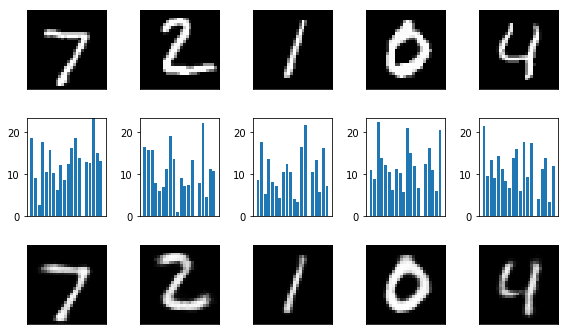

In [37]:
# show the input data, its latent values, and the corresponding predicted images
np.random.seed(random_seed)
encoder_predictions = model_encoder_only_model.predict(X_test)

plt.figure(figsize=(8, 5))
latent_min = np.min(encoder_predictions[0:5])
latent_max = np.max(encoder_predictions[0:5])
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_test[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.subplot(3, 5, i+6)
    plt.bar(np.arange(len(encoder_predictions[i])), encoder_predictions[i])
    plt.xticks([], [])
    plt.ylim(latent_min, latent_max)
    
    plt.subplot(3, 5, i+11)
    decoder_model_input = np.resize(encoder_predictions[i], (1, len(encoder_predictions[i])))
    decoder_prediction = model_decoder_only_model.predict(decoder_model_input)
    plt.imshow(decoder_prediction.reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
file_helper.save_figure("model-F-latents-and-output")
plt.show()

In [38]:
# show the latent values and the corresponding predicted images
# this makes big vertical spaces between the 
def show_latents_and_predictions(predictions, filename=None):
    plt.figure(figsize=(8, 4))
    latent_min = np.min(predictions[0:5])
    latent_max = np.max(predictions[0:5])
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.bar(np.arange(len(predictions[i])), predictions[i])
        plt.xticks([], [])
        plt.ylim(latent_min, latent_max)

        plt.subplot(2, 5, i+6)
        decoder_model_input = np.resize(predictions[i], (1, len(predictions[i])))
        decoder_prediction = model_decoder_only_model.predict(decoder_model_input)
        plt.imshow(decoder_prediction.reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    file_helper.save_figure(filename)
    plt.show()

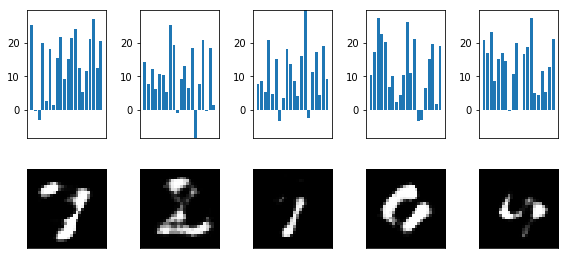

In [39]:
# add [-noise to all values
encoder_predictions = np.array(model_encoder_only_model.predict(X_test))
np.random.seed(random_seed)
noise = 10
for i in range(encoder_predictions.shape[0]):
    for j in range(len(encoder_predictions[i])):
        encoder_predictions[i][j] += np.random.uniform(low=-noise, high=noise)
show_latents_and_predictions(encoder_predictions, 'NB2-MLP-AE5-prediction-latent-values-with-noise-1')